# Sentinel-2 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)


## Background

Sentinel-2 is an Earth observation mission from the EU Copernicus Programme that systematically acquires optical imagery at high spatial resolution (up to 10 m for some bands). The mission is based on a constellation of two identical satellites in the same orbit, 180° apart for optimal coverage and data delivery. Together, they cover all Earth's land surfaces, large islands, inland and coastal waters every 3-5 days.

Digital Earth Africa provides [Sentinel-2, Level 2A](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a-processing) (processed to Level 2A using the Sen2Cor algorithm) surface reflectance data. Surface reflectance provides standardised optical datasets by using robust physical models to correct for variations in image radiance values due to atmospheric properties, as well as sun and sensor geometry, resulting an Analysis Ready Data (ARD) product. ARD allows you to analyse surface reflectance data as is without the need to apply additional corrections.  The resulting stack of surface reflectance grids are consistent over space and time, which is instrumental in identifying and quantifying environmental change.

Sentinel-2A and Sentinel-2B satellite sensors are stored together under a single product name: `'s2_l2a'`

**Important details:**

* Surface reflectance product (Level 2A)
    * Valid SR scaling range: `1 – 10,000 (0 is no-data)`
* [SCL](https://earth.esa.int/web/sentinel/technical-guides/sentinel-2-msi/level-2a/algorithm) used as pixel quality band
* Date-range: 2017 &ndash; present
* Spatial resolution: 10, 20 & 60m

> Note: For a detailed description of DE Africa's Sentinel-2 archive, see DE Africa's [Sentinel-2 technical docs](https://docs.digitalearthafrica.org/en/latest/data_specs/Sentinel-2_Level-2A_specs.html)

## Description

In this notebook we will load Sentinel-2 data using two methods. Firstly, we will use `dc.load()` to return a time series of satellite images. Secondly, we will load a time series using the `load_ard()` function, which is a wrapper function around the dc.load module. This function will load all the images from Sentinel-2 and apply a cloud mask. The returned xarray.Dataset will contain analysis ready images with the cloudy and invalid pixels masked out.

Topics covered include:
1. Inspecting the Sentinel-2 product and measurements available in the datacube
2. Using the native `dc.load()` function to load in Sentinel-2 data
3. Using the `load_ard()` wrapper function to load in a cloud and pixel-quality masked time series

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell.

### Load packages

In [1]:
import datacube

from deafrica_tools.datahandling import load_ard
from deafrica_tools.plotting import rgb

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


### Connect to the datacube

In [2]:
dc = datacube.Datacube(app='Sentinel-2')

## Available products and measurements

### List products

We can use datacube's `list_products` functionality to inspect the DE Africa's Sentinel-2 products that are available in the datacube. The table below shows the product names that we will use to load the data, a brief description of the data, and the satellite instrument that acquired the data.


In [3]:
# List Sentinel-2 products available in DE Africa
dc_products = dc.list_products()
display_columns = ['name', 'description']
dc_products[dc_products.name.str.contains(
    's2_l2a').fillna(
        False)][display_columns].set_index('name')

,description
name,
s2_l2a,"Sentinel-2a and Sentinel-2b imagery, processed..."


### List measurements

We can further inspect the data available for the Sentinel-2 using datacube's `list_measurements` functionality. The table below lists each of the measurements available in the data.


In [4]:
dc_measurements = dc.list_measurements()
dc_measurements.loc['s2_l2a']

,name,dtype,units,nodata,aliases,flags_definition
measurement,,,,,,
B01,B01,uint16,1,0,"[band_01, coastal_aerosol]",NaN
B02,B02,uint16,1,0,"[band_02, blue]",NaN
B03,B03,uint16,1,0,"[band_03, green]",NaN
B04,B04,uint16,1,0,"[band_04, red]",NaN
B05,B05,uint16,1,0,"[band_05, red_edge_1]",NaN
B06,B06,uint16,1,0,"[band_06, red_edge_2]",NaN
B07,B07,uint16,1,0,"[band_07, red_edge_3]",NaN
B08,B08,uint16,1,0,"[band_08, nir, nir_1]",NaN
B8A,B8A,uint16,1,0,"[band_8a, nir_narrow, nir_2]",NaN


## Load Sentinel-2 data using `dc.load()`

Now that we know what products and measurements are available for the products, we can load data from the datacube using `dc.load`.

In the example below, we will load data from Sentinel-2 from the Cape of Good Hope, SA in January 2018. We will load data from three spectral satellite bands, as well as cloud masking data (`'SCL'`). By specifying `output_crs='EPSG:6933'` and `resolution=(-10, 10)`, we request that datacube reproject our data to the African Albers coordinate reference system (CRS), with 10 x 10 m pixels. Finally, `group_by='solar_day'` ensures that overlapping images taken within seconds of each other as the satellite passes over are combined into a single time step in the data.

> Note: For a more general discussion of how to load data using the datacube, refer to the [Introduction to loading data](../Beginners_guide/03_Loading_data.ipynb) notebook.

> Note: Be aware that setting `resolution` to the highest available resolution (i.e. `resolution=(-10, 10)`) will downsample the coarser resolution 20 m and 60 m bands, which may introduce unintended artefacts into your analysis. It is typically best practice to set `resolution` to match the lowest resolution band being analysed. For example, if your analysis uses both 10 m and 20 m resolution bands, set `resolution=(-20, 20)`.

In [5]:
# load data
ds = dc.load(product="s2_l2a",
             measurements=['red', 'green', 'blue', 'SCL'],
             y=(-34.31, -34.36),
             x=(18.44, 18.50),
             time=("2018-01", "2018-01"),
             resolution=(-10, 10),
             output_crs='EPSG:6933',
             group_by="solar_day",
             )

print(ds)

<xarray.Dataset>
Dimensions:      (time: 7, x: 580, y: 529)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T08:42:22 ... 2018-01-31T08:...
  * y            (y) float64 -4.126e+06 -4.126e+06 ... -4.131e+06 -4.131e+06
  * x            (x) float64 1.779e+06 1.779e+06 ... 1.785e+06 1.785e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 10584 10648 10696 10696 ... 76 130 218 168
    green        (time, y, x) uint16 10896 10920 11080 11080 ... 122 138 284 256
    blue         (time, y, x) uint16 11672 11680 11680 11680 ... 107 142 244 298
    SCL          (time, y, x) uint8 9 9 9 9 9 9 9 9 9 9 ... 6 6 6 6 6 6 6 6 6 6
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref



### Plotting Sentinel-2 data

We can plot the data we loaded using the rgb function. By default, the function will plot data as a true colour image using the 'red', 'green', and 'blue' bands.


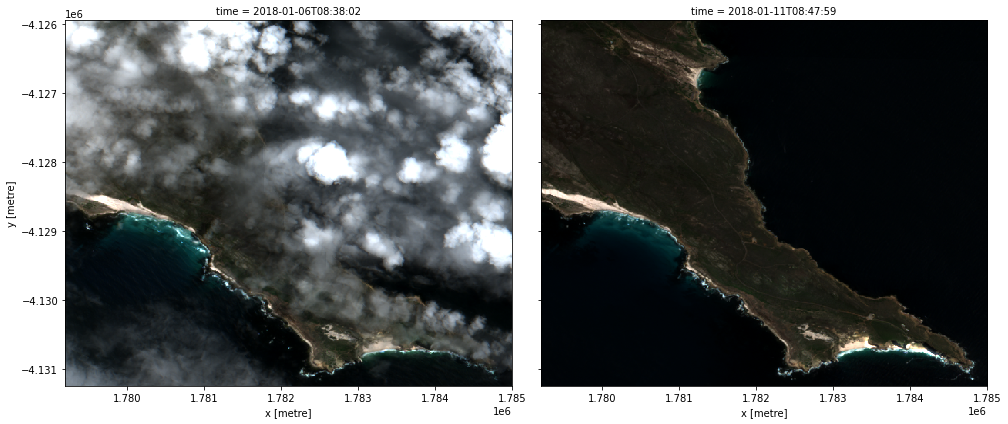

In [6]:
rgb(ds, index=[1,2])

## Load Sentinel-2 using `load_ard`

This function will load images from Sentinel-2 and apply a cloud/pixel-quality mask.
The result is an analysis ready dataset free of cloud, cloud-shadow, and missing data.

You can find more information on this function from the [Using load ard](../Frequently_used_code/Using_load_ard.ipynb) notebook.

In [7]:
ds = load_ard(dc=dc,
              products=["s2_l2a"],
              measurements=['red', 'green', 'blue'],
              y=(-34.31, -34.36),
              x=(18.44, 18.50),
              time=("2018-01", "2018-01"),
              resolution=(-10, 10),
              output_crs='EPSG:6933',
              group_by="solar_day",
              dtype='native'
             )

print(ds)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Applying pixel quality/cloud mask
Loading 7 time steps
<xarray.Dataset>
Dimensions:      (time: 7, x: 580, y: 529)
Coordinates:
  * time         (time) datetime64[ns] 2018-01-01T08:42:22 ... 2018-01-31T08:...
  * y            (y) float64 -4.126e+06 -4.126e+06 ... -4.131e+06 -4.131e+06
  * x            (x) float64 1.779e+06 1.779e+06 ... 1.785e+06 1.785e+06
    spatial_ref  int32 6933
Data variables:
    red          (time, y, x) uint16 0 0 0 0 0 0 0 0 ... 69 67 95 76 130 218 168
    green        (time, y, x) uint16 0 0 0 0 0 0 0 ... 149 153 122 138 284 256
    blue         (time, y, x) uint16 0 0 0 0 0 0 0 ... 162 137 107 142 244 298
Attributes:
    crs:           EPSG:6933
    grid_mapping:  spatial_ref


Below we plot the cloud masked Sentinel-2 data.

> Note: In the left image, notice that the Sentinel-2 cloud mask (`SCL` band) fails to identify a lot of the cloud cover. In the image on the right, some of the bright, white coastline has been miss-classified as cloud. These are known limitations of the Sentinel-2 cloud mask, and users should be wary of these limitations when conducting analyses.

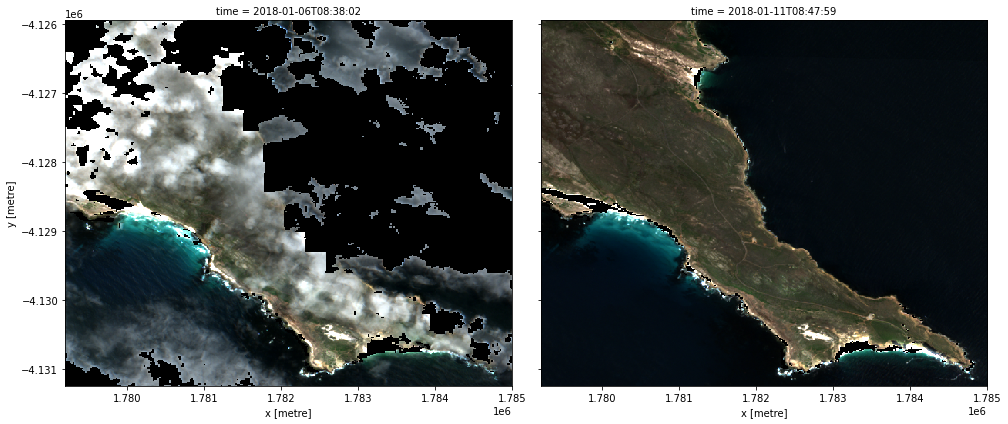

In [8]:
rgb(ds, index=[1,2])

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:** 

In [9]:
print(datacube.__version__)

1.8.4.dev52+g07bc51a5


**Last Tested:**

In [10]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-05-20'